    # Output CN plot

In [12]:
import matplotlib
import matplotlib.pyplot as plt
# imports
import scgenome.plotting as pl
import h5py
import anndata
import numpy as np

In [13]:
import os
print(os.getcwd())


/Users/haraldme/git/Lagergren Lab/CopyTree/VICTree/victree/src/experiments


In [14]:
import json
base_path = "../../output/bahlis_10x"
data_base_path = '../../data/bahlis_10x/patient_MM-03.h5ad'
patient_name = "patient_MM-03"
hyper_params = "K8L5i100step0p3splitMixed3ClustersLambda100kqTmst"
experiment_seed = ""
path = os.path.join(base_path, patient_name)
path = os.path.join(path, hyper_params)
path = os.path.join(path, experiment_seed)

out_file = anndata.read_h5ad(os.path.join(path, 'victree.out.h5ad')) # 014
model_file = h5py.File(os.path.join(path, 'victree.model.h5')) # 014
with open(os.path.join(path, "victree.config.json")) as file:
    config_file = json.load(file)

print(f'out file keys: {out_file}')
print(f'model file keys: {model_file.keys()}')
print(f'config keys: {config_file}')

adata = anndata.read_h5ad(data_base_path)

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


out file keys: AnnData object with n_obs × n_vars = 2208 × 5298
    obs: 'victree-mu', 'victree-mt-lambda', 'victree-mt-alpha', 'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'
    var: 'target_bin', 'chr', 'start', 'end'
    uns: 'victree-eps-alpha', 'victree-eps-beta', 'victree-tree-graph', 'victree-tree-newick', 'victree-tree-probs'
    obsm: 'victree-clone-probs'
    varm: 'victree-cn-pprobs', 'victree-cn-sprobs'
    layers: 'victree-cn-marginal', 'victree-cn-viterbi'
model file keys: <KeysViewHDF5 ['VarTreeJointDist', 'qCMultiChrom', 'qEpsilonMulti', 'qMuTau', 'qPi', 'qT', 'qZ']>
config keys: {'qT_temp': 500.0, 'merge_and_split_interval': 5, 'step_size_delay': 2.0, 'step_size_forgetting_rate': 0.7, 'step_size_scheme': 'None', 'batch_size': 20, 'SVI': False, 'split': 'ELBO', 'curr_it': 50, 'qc_smoothing': False, '_diagnostics': True, 'step_size': 0.3, 'annealing': 1.0, '_n_nodes': 10, '_n_states': 7, '_eps0': 0.01, '_n_cells': 2208, '_chain_length': 5298, '_n_chr

In [15]:
print(out_file.layers.keys())
print(out_file.obs.keys())

KeysView(Layers with keys: victree-cn-marginal, victree-cn-viterbi)
Index(['victree-mu', 'victree-mt-lambda', 'victree-mt-alpha',
       'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'],
      dtype='object')


In [16]:
# get cell assignment and cell copy number
top_z = out_file.obsm['victree-clone-probs'][...].argmax(axis=1)
clone_cn_np = out_file.layers['victree-cn-marginal'][...].argmax(axis=-1)
cell_cn = clone_cn_np[top_z, :]

In [17]:
chr_codes = {c: c[3:] for c in adata.var['chr'].unique()}
adata.var['chr'] = adata.var['chr'].map(chr_codes)

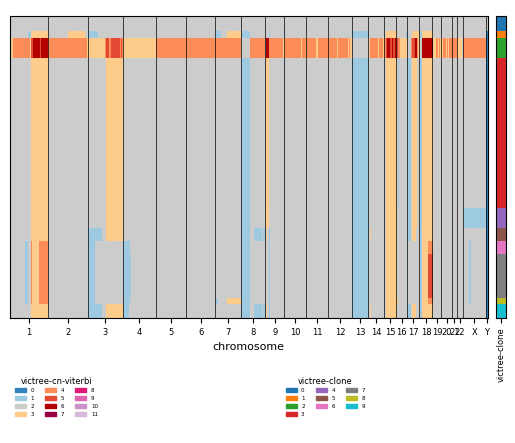

In [18]:
%matplotlib inline
#out_file.layers['victree-cn-marginal'] = cell_qc.get_viterbi()[1:].numpy()
g = pl.plot_cell_cn_matrix_fig(out_file, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'], max_cn=7)

In [19]:
E_q_mu = out_file.obs['victree-mu']
print(f"E_q[mu] max: {E_q_mu.max()} min: {E_q_mu.min()}")

E_q[mu] max: 1.3610777854919434 min: 0.8619913458824158


In [20]:
adata.obs['victree-clone'] = out_file.obs['victree-clone']
adata.obs['clone'] = top_z

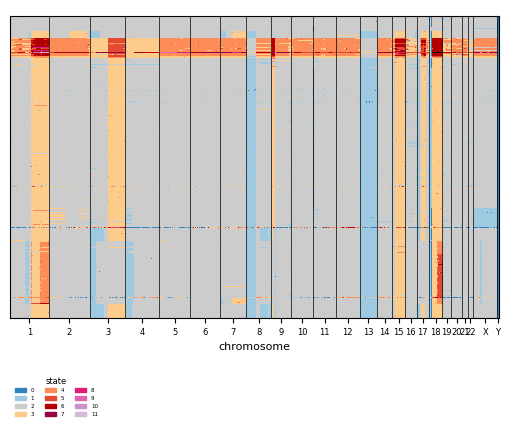

In [21]:
g = pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['clone'])

<Axes: xlabel='chromosome'>

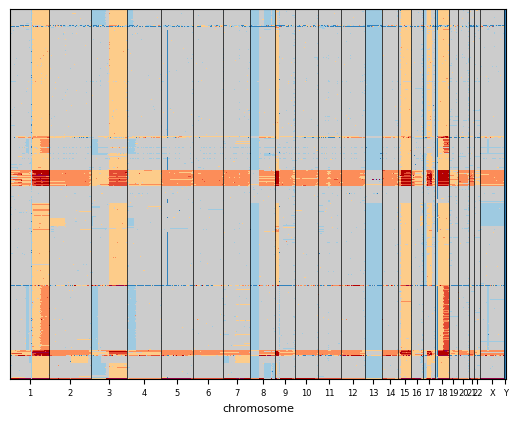

In [22]:
pl.plot_cell_cn_matrix(adata, 'state', cell_order_fields=['cluster_id'], max_cn=7)['ax']

/var/folders/gt/k64xtzx97m9dchpngd2j_xp40000gp/T/ipykernel_48742/4006104823.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(mst, prog="dot")


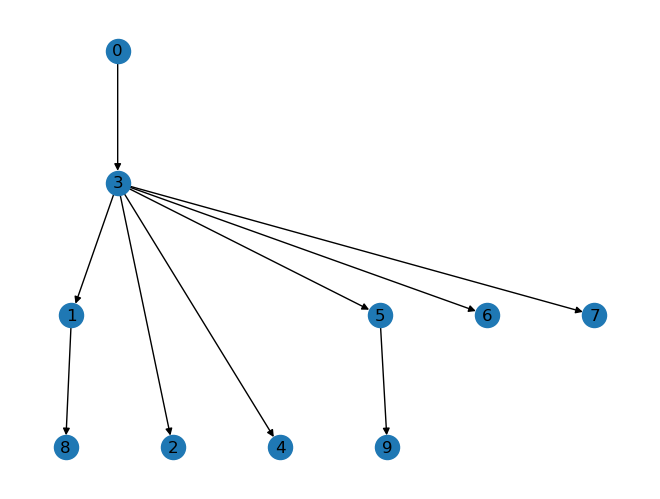

In [23]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
adj_matrix = out_file.uns['victree-tree-graph']
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mst = nx.maximum_spanning_arborescence(G)
pos = graphviz_layout(mst, prog="dot")
nx.draw(mst, pos=pos, with_labels=True)

In [24]:
qZ_probs = out_file.obsm['victree-clone-probs'][...]
clonal_fractions = np.mean(qZ_probs, axis=0)
print(clonal_fractions)

[0.05145624 0.0211246  0.06520255 0.4983212  0.06601208 0.04236415
 0.04485025 0.1440462  0.01990297 0.0467199 ]


In [18]:
import numpy as np
np.unique(top_z, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 31, 283, 121,  44,  64,  32,  39,  27,  42]))

In [19]:
out_file['result']['trees'].keys()

KeyError: 'result'

In [33]:

for t in zip(out_file['result']['trees']['newick'], out_file['result']['trees']['weight']):
    print(t[0])
    print(t[1])
    print('---')

b'((2,(1,5)4)3)0'
0.02043939
---
b'((((5)2)1,3)4)0'
0.013640878
---
b'(((5)1,(3)2)4)0'
0.013598051
---
b'(1,(2,(5)3)4)0'
0.013593179
---
b'((2,(3)4)1,5)0'
0.013571922
---
b'((3,5)2,(1)4)0'
0.013564752
---
b'(2,(1,4)3,5)0'
0.01355846
---
b'((1,4)2,3,5)0'
0.013556236
---
b'((2,((5)3)4)1)0'
0.013550264
---
b'((1)2,(4,5)3)0'
0.013547564
---
b'((1,(3)2,5)4)0'
0.013543362
---
b'(((4,5)2,3)1)0'
0.013538791
---
b'(((2,3)4,5)1)0'
0.0135366
---
b'((1,(2,5)4)3)0'
0.0135211
---
b'((4)1,(2,5)3)0'
0.013488823
---
b'(((3)1,5)2,4)0'
0.013478719
---
b'(1,(((5)2)4)3)0'
0.013476964
---
b'((2,(3,5)4)1)0'
0.013476209
---
b'(2,((1,5)4)3)0'
0.0134605905
---
b'(((2,(5)4)1)3)0'
0.01343996
---
b'((3,5)1,(4)2)0'
0.0134385275
---
b'(((5)2,3)1,4)0'
0.013409871
---
b'(((3)1)2,(5)4)0'
0.013383034
---
b'((2)1,(5)3,4)0'
0.013311512
---
b'(((3,(1)4)2)5)0'
0.012144192
---
b'(((1,(4)2)3)5)0'
0.012141792
---
b'(((1,2,4)3)5)0'
0.012141299
---
b'((((4)1,2)3)5)0'
0.01205685
---
b'((((1)5)2,3)4)0'
0.012046414
---
b'(((((1)5)3